In [1]:
import os
import onnx
import torch

model_dir = os.environ['FINN_ROOT'] + "/notebooks/end2end_example/cnn-dizeratie"
print("Model dir:", model_dir)
torch.set_num_threads(2)

Model dir: /home/stefan/finn/notebooks/end2end_example/cnn-dizeratie


In [2]:
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 KB 805.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 KB 11.4 MB/s eta 0:00:00


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!mkdir -p data_uta_rldd
!kaggle datasets download -d minhngt02/uta-rldd -p data_uta_rldd --force
!ls data_uta_rldd

Dataset URL: https://www.kaggle.com/datasets/minhngt02/uta-rldd
License(s): CC0-1.0
 99%|██████████████████████████████████████▊| 2.75G/2.77G [00:04<00:00, 372MB/s]
100%|███████████████████████████████████████| 2.77G/2.77G [00:10<00:00, 293MB/s]
UTA_RLDD_raw  uta-rldd.zip


In [5]:
!unzip -oq data_uta_rldd/uta-rldd.zip -d data_uta_rldd/UTA_RLDD_raw
print("Unzip completed.")

Unzip completed.


In [6]:
import os
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder

# -------------------------------------------------------
# 1. Root folder where you unzipped the UTA-RLDD Kaggle dataset
#    Adjust this path to match your environment.
# -------------------------------------------------------
uta_root = "data_uta_rldd/UTA_RLDD_raw"   # <-- change if needed

train_root = os.path.join(uta_root, "train")
val_root   = os.path.join(uta_root, "val")
test_root  = os.path.join(uta_root, "test")

# -------------------------------------------------------
# 2. Transforms: resize to 128x128, tensor + normalization
# -------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

# 2) No augmentation, only resize + normalize: VAL/TEST
eval_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                          std=[0.5, 0.5, 0.5]),
# ])

# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
# ])

full_dataset = ImageFolder(root= os.path.join(uta_root, "train") , transform=transform)
# -------------------------------------------------------
# 3. Build train / val / test datasets from folders
# -------------------------------------------------------
train_quantized_dataset = ImageFolder(root=train_root, transform=transform)
val_quantized_dataset   = ImageFolder(root=val_root,   transform=eval_transform)
test_quantized_dataset  = ImageFolder(root=test_root,  transform=eval_transform)

print("Classes:", train_quantized_dataset.classes)
print("Train images:", len(train_quantized_dataset))
print("Val   images:", len(val_quantized_dataset))
print("Test  images:", len(test_quantized_dataset))

# Inspect one sample from train
x0, y0 = train_quantized_dataset[0]
print("Sample shape:", x0.shape)        # (3, 128, 128)
print("Sample label index:", y0)        # 0 or 1
print("Label name:", train_quantized_dataset.classes[y0])
print("Class names:", full_dataset.classes)

Classes: ['active', 'fatigue']
Train images: 9054
Val   images: 1824
Test  images: 909
Sample shape: torch.Size([3, 128, 128])
Sample label index: 0
Label name: active
Class names: ['active', 'fatigue']


Random TRAIN sample:


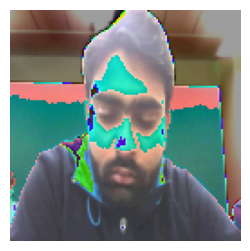

Title: Train sample
Label index: 0
--------------------------------------------------
Random TEST sample:


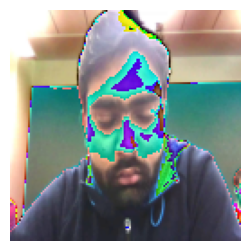

Title: Test sample
Label index: 1
--------------------------------------------------


In [7]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show_random_sample_from_subset(subset, title):
    # subset is a torch.utils.data.Subset
    # subset.dataset is the underlying ImageFolder
    # subset.indices is the list of indices into the ImageFolder

    # pick a random index inside the subset
    subset_idx = random.randint(0, len(subset) - 1)
    # real_idx = subset.indices[subset_idx]   # index inside ImageFolder

    # get image + label
    img, label = subset[subset_idx]

    # get file path
    # filepath, _ = subset.dataset.samples[real_idx]

    # convert tensor to PIL for display
    img_pil = F.to_pil_image(img)

    plt.figure(figsize=(3, 3))
    plt.imshow(img_pil)
    # plt.title(f"{title}\nLabel: {subset.dataset.classes[label]}")
    plt.axis("off")
    plt.show()

    # also print details in text
    print(f"Title: {title}")
    print(f"Label index: {label}")
    # print(f"Label name: {subset.dataset.classes[label]}")
    # print(f"File path: {filepath}")
    print("--------------------------------------------------")


print("Random TRAIN sample:")
show_random_sample_from_subset(train_quantized_dataset, "Train sample")

print("Random TEST sample:")
show_random_sample_from_subset(test_quantized_dataset, "Test sample")


In [8]:
from torch.utils.data import DataLoader

batch_size = 16   # safer for larger images; adjust later if needed

train_quantized_loader = DataLoader(
    train_quantized_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,      # try 4; reduce to 0 if errors
    pin_memory=False
)

test_quantized_loader = DataLoader(
    test_quantized_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=False
)

val_quantized_loader = DataLoader(
    val_quantized_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=False
)

In [9]:
count = 0
for x, y in train_quantized_loader:
    print("Input shape for 1 batch: " + str(x.shape))
    print("Label shape for 1 batch: " + str(y.shape))
    count += 1
    if count == 1:
        break

Input shape for 1 batch: torch.Size([16, 3, 128, 128])
Label shape for 1 batch: torch.Size([16])


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target device: " + str(device))

Target device: cpu


In [11]:
num_classes = len(full_dataset.classes) 
print("Number of classes:", num_classes, "->", full_dataset.classes)

Number of classes: 2 -> ['active', 'fatigue']


In [12]:
#### MODEL 6 #### 

from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN(nn.Module):
    """
    Lighter version of the Keras-style model:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Flatten -> Dropout(0.5) -> Dense(32) -> Dense(num_classes)
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # --------- Block 1: 3 -> 16 ---------
        self.conv1 = QuantConv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool1 = nn.MaxPool2d(2, 2)   # H,W: 128 -> 64

        # --------- Block 2: 16 -> 32 ---------
        self.conv2 = QuantConv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act2 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool2 = nn.MaxPool2d(2, 2)   # 64 -> 32

        # --------- Block 3: 32 -> 32 ---------
        self.conv3 = QuantConv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act3 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool3 = nn.MaxPool2d(2, 2)   # 32 -> 16

        # --------- Block 4: 32 -> 32 ---------
        self.conv4 = QuantConv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act4 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool4 = nn.MaxPool2d(2, 2)   # 16 -> 8

        # --------- Compute feature_dim automatically ---------
        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]   # should be 32 * 8 * 8 = 2048 for 128x128

        # --------- Dropout + FC layers ---------
        self.dropout = nn.Dropout(p=0.5)

        self.fc1 = QuantLinear(
            in_features=self.feature_dim,
            out_features=32,   # smaller hidden layer
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act_fc1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )

        self.fc2 = QuantLinear(
            in_features=32,
            out_features=num_classes,   # 2 for drowsy/active
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)   # flatten
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.fc2(x)             # logits
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=input_h,
#     input_width=input_w,
# ).to(device)

# print(model)
# print("feature_dim:", model.feature_dim)

In [13]:
#############################
######## MODEL 6.1 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_1(nn.Module):
    """
    Model 6.1:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Flatten -> Dropout(0.3) -> FC(64) -> ReLU -> Dropout(0.3) -> FC(num_classes)
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 3: 32 -> 32, 32 -> 16
        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Block 4: 32 -> 32, 16 -> 8
        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        # feature dim
        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # for 128: 32*8*8 = 2048

        # Head
        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN_6_1(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=128,
#     input_width=128
# ).to(device)

# print(model.name)
# print("feature_dim:", model.feature_dim)


In [14]:
#############################
######## MODEL 6.2 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_2(nn.Module):
    """
    Model 6.2:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(48) + MaxPool
      Conv(64) + MaxPool
      Flatten -> Dropout(0.3) -> FC(64) -> ReLU -> Dropout(0.3) -> FC(num_classes)
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 3: 32 -> 48, 32 -> 16
        self.conv3 = QuantConv2d(32, 48, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Block 4: 48 -> 64, 16 -> 8
        self.conv4 = QuantConv2d(48, 64, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 64*8*8 = 4096

        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN_6_2(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=128,
#     input_width=128
# ).to(device)

# print(model)
# print("feature_dim:", model.feature_dim)


In [15]:
#############################
######## MODEL 6.3 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_3(nn.Module):
    """
    Model 6.3:
      Same as Model 6 conv widths, but adds Dropout2d(p=0.1) in the conv trunk
      (training-only) + head like 6.1.
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Dropout2d in trunk (training-only)
        self.drop2 = nn.Dropout2d(p=0.1)

        # Block 3: 32 -> 32, 32 -> 16
        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.drop3 = nn.Dropout2d(p=0.1)

        # Block 4: 32 -> 32, 16 -> 8
        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.drop2(x)
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.drop3(x)
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*8*8 = 2048

        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.drop2(x)
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.drop3(x)
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN_6_3(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=128,
#     input_width=128
# ).to(device)

# print(model)
# print("feature_dim:", model.feature_dim)


In [16]:
### Model 8 ### 

from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class Model8_Bottleneck1x1(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        # Block 1: 3 -> 16 -> (1x1) -> 8, pool
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                                 weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.conv1b = QuantConv2d(16, 8, 1, 1, 0, bias=True, weight_bit_width=w_bit,
                                  weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1b  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)  # 128->64

        # Block 2: 8 -> 16 -> (1x1) -> 16, pool
        self.conv2 = QuantConv2d(8, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                                 weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.conv2b = QuantConv2d(16, 16, 1, 1, 0, bias=True, weight_bit_width=w_bit,
                                  weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2b  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)  # 64->32

        # Block 3: 16 -> 32, pool
        self.conv3 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                                 weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)  # 32->16

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1b(self.conv1b(self.act1(self.conv1(dummy)))))
            x = self.pool2(self.act2b(self.conv2b(self.act2(self.conv2(x)))))
            x = self.pool3(self.act3(self.conv3(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1b(self.conv1b(self.act1(self.conv1(x)))))
        x = self.pool2(self.act2b(self.conv2b(self.act2(self.conv2(x)))))
        x = self.pool3(self.act3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [17]:
### Model 9 ### 
class Model9_VGGLite(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        # Stage 1: 3 -> 16 -> 16, pool (128->64)
        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c1b = QuantConv2d(16, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        # Stage 2: 16 -> 32 -> 32, pool (64->32)
        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c2b = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        # Stage 3: 32 -> 48, pool (32->16)
        self.c3 = QuantConv2d(32, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1b(self.c1b(self.a1(self.c1(dummy)))))
            x = self.p2(self.a2b(self.c2b(self.a2(self.c2(x)))))
            x = self.p3(self.a3(self.c3(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1b(self.c1b(self.a1(self.c1(x)))))
        x = self.p2(self.a2b(self.c2b(self.a2(self.c2(x)))))
        x = self.p3(self.a3(self.c3(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [18]:
### Model 10 ###
class Model10_MorePooling(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)  # 128->64

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)  # 64->32

        self.c3 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)  # 32->16

        self.c4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)  # 16->8

        self.c5 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a5 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p5 = nn.MaxPool2d(2,2)  # 8->4  (this is the point)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(dummy)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            x = self.p5(self.a5(self.c5(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*4*4 = 512

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = self.p5(self.a5(self.c5(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [19]:
### Model 11 ### 
class Model11_CappedChannels(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(24, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(24, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)  # 128->64->32->16->8

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(dummy)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*8*8 = 2048

        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [20]:
### Model 12 ###

class Model12_ShrinkBeforeFC(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        
        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)  # 128->64

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)  # 64->32

        self.c3 = QuantConv2d(32, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)  # 32->16

        # 1x1 squeeze: 48 -> 16 (cheap)
        self.squeeze = QuantConv2d(48, 16, 1, 1, 0, bias=True, weight_bit_width=w_bit,
                                   weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_sq = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)  # 16->8

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(dummy)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a_sq(self.squeeze(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 16*8*8 = 1024

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a_sq(self.squeeze(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [21]:
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch


In [22]:
class Model13_VGGmini(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        self.conv1 = QuantConv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            groups=1,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool1 = nn.MaxPool2d(2, 2)   # 128->64

        self.conv2 = QuantConv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            groups=1,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act2 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool2 = nn.MaxPool2d(2, 2)   # 64->32

        self.conv3 = QuantConv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            groups=1,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act3 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool3 = nn.MaxPool2d(2, 2)   # 32->16

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(
            in_features=self.feature_dim,
            out_features=64,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act_fc1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.fc2 = QuantLinear(
            in_features=64,
            out_features=num_classes,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [23]:
class Model14_VGGmini_morepool(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(
            in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)   # 128->64

        self.conv2 = QuantConv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)   # 64->32

        self.conv3 = QuantConv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)   # 32->16

        self.pool4 = nn.MaxPool2d(2, 2)   # 16->8

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(
            in_features=self.feature_dim, out_features=64, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(
            in_features=64, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [24]:
class Model15_2conv_stages(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        # Stage 1
        self.c11 = QuantConv2d(
            in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a11 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c12 = QuantConv2d(
            in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a12 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)  # 128 -> 64

        # Stage 2
        self.c21 = QuantConv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a21 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c22 = QuantConv2d(
            in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a22 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)  # 64 -> 32

        # Stage 3
        self.c31 = QuantConv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a31 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2, 2)  # 32 -> 16

        # feature_dim
        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a12(self.c12(self.a11(self.c11(d)))))
            x = self.p2(self.a22(self.c22(self.a21(self.c21(x)))))
            x = self.p3(self.a31(self.c31(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        # head
        self.fc1 = QuantLinear(
            in_features=self.feature_dim, out_features=64, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(
            in_features=64, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.p1(self.a12(self.c12(self.a11(self.c11(x)))))
        x = self.p2(self.a22(self.c22(self.a21(self.c21(x)))))
        x = self.p3(self.a31(self.c31(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)



In [25]:
class Model16_wide_early(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(
            in_channels=3, out_channels=24, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(
            in_channels=24, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(
            in_channels=32, out_channels=48, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.pool4 = nn.MaxPool2d(2, 2)  # -> 8x8

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(
            in_features=self.feature_dim, out_features=64, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(
            in_features=64, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [26]:
class Model17_deeper_4blocks(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(32, 64, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = QuantConv2d(64, 64, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc = QuantLinear(
            in_features=self.feature_dim, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [27]:
class Model18_bigger_head(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 128, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.fc2 = QuantLinear(128, 64, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.fc3 = QuantLinear(64, num_classes, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.act_fc2(self.fc2(x))
        return self.fc3(x)


In [28]:
class Model19_lowchan_deeper(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.c1 = QuantConv2d(3, 12, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)

        self.c2 = QuantConv2d(12, 16, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)

        self.c3 = QuantConv2d(16, 20, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2, 2)

        self.c4 = QuantConv2d(20, 24, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [29]:
class Model20_all32(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.c1 = QuantConv2d(3, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)

        self.c2 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)

        self.c3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2, 2)

        self.c4 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc = QuantLinear(self.feature_dim, num_classes, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [30]:
class Model21_late64(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = QuantConv2d(32, 64, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [31]:
class Model22_extra_conv_mid(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.c1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)

        self.c2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)

        self.c3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c4 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.p3 = nn.MaxPool2d(2, 2)
        self.p4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.a3(self.c3(x))
            x = self.a4(self.c4(x))
            x = self.p3(x)
            x = self.p4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc = QuantLinear(self.feature_dim, num_classes, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.a3(self.c3(x))
        x = self.a4(self.c4(x))
        x = self.p3(x)
        x = self.p4(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [32]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()   
                
        # forward pass
        output = model(inputs.float())      # (batch, num_classes)
        # CrossEntropyLoss expects class indices (0..num_classes-1)
        loss = criterion(output, target.long())
        
        # backward pass + run optimizer to update weights
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.item()) 
           
    return losses


In [33]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, target in loader:
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total


In [34]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

def run_experiment(build_model_fn, exp_name, num_epochs):
    
    model = build_model_fn(num_classes=2, w_bit= 4, a_bit = 4, input_height = 128, input_width = 128).to(device)

    print(f"Model to test: {exp_name}")

    # print(model)
    print("feature_dim:", model.feature_dim)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",          # we want to maximize val accuracy
    factor=0.5,          # multiply LR by 0.5
    patience=5,          # wait 5 epochs with no improvement
    verbose=True
    )
    
    print("Criterion:", criterion)
    print("Optimizer:", optimizer)
    print("Scheduler:", scheduler)

    # %%time
    # x = torch.randn(1, 3, 128, 128).to(device)
    # for i in range(100):
    #     y = model(x)
        
    # %%time
    # batch = next(iter(train_quantized_loader))

    running_loss = []
    running_val_acc = []
    
    best_val_acc = 0.0
    best_state_dict = None
    # best_epoch = -1

    t = trange(num_epochs, desc="Training", leave=True)
    
    for epoch in t:
        
        # --- TRAIN ---
        epoch_losses = train(model, train_quantized_loader, optimizer, criterion)
        train_loss = float(np.mean(epoch_losses))

        # --- VALIDATE ---
        val_acc = evaluate(model, val_quantized_loader, device)

        # LR scheduler (based on validation accuracy)
        scheduler.step(val_acc)

        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        running_loss.append(train_loss)
        running_val_acc.append(val_acc)

        t.set_description(
            f"Epoch {epoch+1}/{num_epochs} loss={train_loss:.4f} val_acc={val_acc:.4f} "
            f"best={best_val_acc:.4f}"
        )
        t.refresh()

    print("Best val accuracy:", best_val_acc)

    # Restore best model (optional but usually a good idea)
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        model.to(device)
        
    test_acc = evaluate(model, test_quantized_loader, device)
    print("Final TEST accuracy:", test_acc)

    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(range(1, len(running_val_acc) + 1), running_loss, color="tab:blue", label="Training loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True)
    
    ax2 = ax1.twinx()
    ax2.plot(range(1, len(running_val_acc) + 1), running_val_acc, color="tab:orange", marker='o', label="Validation accuracy")
    ax2.set_ylabel("Accuracy", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    
    fig.suptitle(exp_name)
    fig.tight_layout()
    plt.show()
    
    del model, optimizer, scheduler
    import gc
    gc.collect()
    torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1255: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).rename(names)


Model to test: Model_22
feature_dim: 2048
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7ff27a55db40>


Epoch 8/100 loss=0.5687 val_acc=0.5844 best=0.6957:   8%| | 8/100 [16:26<3:14:09

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/100 loss=0.5496 val_acc=0.7133 best=0.7774:  21%|▏| 21/100 [40:30<2:12:

Epoch 00021: reducing learning rate of group 0 to 2.5000e-04.


Epoch 33/100 loss=0.5400 val_acc=0.7248 best=0.7807:  33%|▎| 33/100 [1:00:41<2:0

Epoch 00033: reducing learning rate of group 0 to 1.2500e-04.


Epoch 39/100 loss=0.5366 val_acc=0.7061 best=0.7807:  39%|▍| 39/100 [1:11:02<1:4

Epoch 00039: reducing learning rate of group 0 to 6.2500e-05.


Epoch 45/100 loss=0.5314 val_acc=0.7385 best=0.7807:  45%|▍| 45/100 [1:22:24<1:4

Epoch 00045: reducing learning rate of group 0 to 3.1250e-05.


Epoch 51/100 loss=0.5308 val_acc=0.7193 best=0.7807:  51%|▌| 51/100 [1:33:15<1:2

Epoch 00051: reducing learning rate of group 0 to 1.5625e-05.


Epoch 57/100 loss=0.5296 val_acc=0.7155 best=0.7807:  57%|▌| 57/100 [1:43:29<1:1

Epoch 00057: reducing learning rate of group 0 to 7.8125e-06.


Epoch 63/100 loss=0.5283 val_acc=0.7352 best=0.7807:  63%|▋| 63/100 [1:53:38<1:0

Epoch 00063: reducing learning rate of group 0 to 3.9063e-06.


Epoch 69/100 loss=0.5279 val_acc=0.7385 best=0.7807:  69%|▋| 69/100 [2:03:50<52:

Epoch 00069: reducing learning rate of group 0 to 1.9531e-06.


Epoch 75/100 loss=0.5292 val_acc=0.7127 best=0.7807:  75%|▊| 75/100 [2:14:00<42:

Epoch 00075: reducing learning rate of group 0 to 9.7656e-07.


Epoch 81/100 loss=0.5300 val_acc=0.7248 best=0.7807:  81%|▊| 81/100 [2:24:11<32:

Epoch 00081: reducing learning rate of group 0 to 4.8828e-07.


Epoch 87/100 loss=0.5268 val_acc=0.7401 best=0.7807:  87%|▊| 87/100 [2:34:20<22:

Epoch 00087: reducing learning rate of group 0 to 2.4414e-07.


Epoch 93/100 loss=0.5310 val_acc=0.7357 best=0.7807:  93%|▉| 93/100 [2:44:32<11:

Epoch 00093: reducing learning rate of group 0 to 1.2207e-07.


Epoch 99/100 loss=0.5283 val_acc=0.7451 best=0.7807:  99%|▉| 99/100 [2:54:37<01:

Epoch 00099: reducing learning rate of group 0 to 6.1035e-08.


Epoch 100/100 loss=0.5283 val_acc=0.7374 best=0.7807: 100%|█| 100/100 [2:56:21<0

Best val accuracy: 0.7807017543859649


Final TEST accuracy: 0.7909790979097909


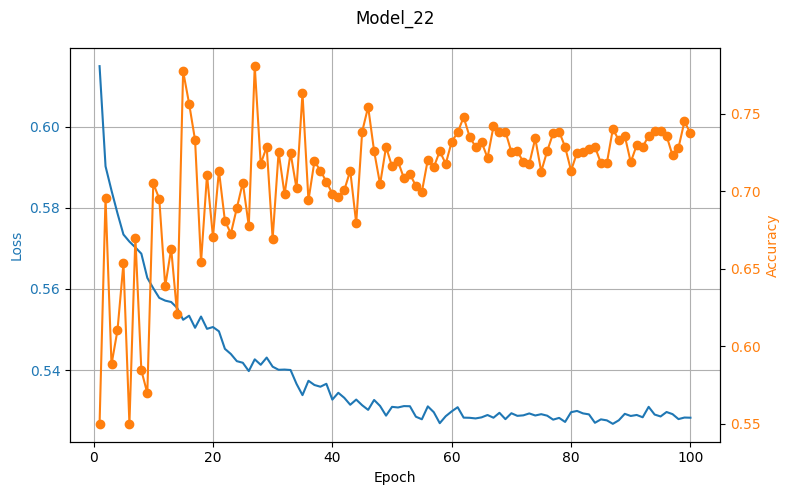

Model to test: Model_14
feature_dim: 4096
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7ff2787b63b0>


Epoch 9/100 loss=0.5601 val_acc=0.6979 best=0.7544:   9%| | 9/100 [16:24<2:44:14

Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/100 loss=0.5474 val_acc=0.7209 best=0.7796:  21%|▏| 21/100 [38:11<2:24:

Epoch 00021: reducing learning rate of group 0 to 2.5000e-04.


Epoch 27/100 loss=0.5418 val_acc=0.6206 best=0.7796:  27%|▎| 27/100 [49:05<2:11:

Epoch 00027: reducing learning rate of group 0 to 1.2500e-04.


Epoch 33/100 loss=0.5361 val_acc=0.6261 best=0.7796:  33%|▎| 33/100 [59:52<2:00:

Epoch 00033: reducing learning rate of group 0 to 6.2500e-05.


Epoch 39/100 loss=0.5342 val_acc=0.6140 best=0.7796:  39%|▍| 39/100 [1:10:46<1:5

Epoch 00039: reducing learning rate of group 0 to 3.1250e-05.


Epoch 45/100 loss=0.5326 val_acc=0.6294 best=0.7796:  45%|▍| 45/100 [1:21:43<1:3

Epoch 00045: reducing learning rate of group 0 to 1.5625e-05.


Epoch 51/100 loss=0.5320 val_acc=0.6223 best=0.7796:  51%|▌| 51/100 [1:32:50<1:3

Epoch 00051: reducing learning rate of group 0 to 7.8125e-06.


Epoch 57/100 loss=0.5314 val_acc=0.6217 best=0.7796:  57%|▌| 57/100 [1:43:39<1:1

Epoch 00057: reducing learning rate of group 0 to 3.9063e-06.


Epoch 63/100 loss=0.5312 val_acc=0.6190 best=0.7796:  63%|▋| 63/100 [1:54:28<1:0

Epoch 00063: reducing learning rate of group 0 to 1.9531e-06.


Epoch 69/100 loss=0.5308 val_acc=0.6206 best=0.7796:  69%|▋| 69/100 [2:05:28<56:

Epoch 00069: reducing learning rate of group 0 to 9.7656e-07.


Epoch 75/100 loss=0.5306 val_acc=0.6245 best=0.7796:  75%|▊| 75/100 [2:16:14<45:

Epoch 00075: reducing learning rate of group 0 to 4.8828e-07.


Epoch 81/100 loss=0.5319 val_acc=0.6245 best=0.7796:  81%|▊| 81/100 [2:27:08<34:

Epoch 00081: reducing learning rate of group 0 to 2.4414e-07.


Epoch 87/100 loss=0.5309 val_acc=0.6245 best=0.7796:  87%|▊| 87/100 [2:38:05<23:

Epoch 00087: reducing learning rate of group 0 to 1.2207e-07.


Epoch 93/100 loss=0.5318 val_acc=0.6239 best=0.7796:  93%|▉| 93/100 [2:48:53<12:

Epoch 00093: reducing learning rate of group 0 to 6.1035e-08.


Epoch 99/100 loss=0.5312 val_acc=0.6239 best=0.7796:  99%|▉| 99/100 [2:59:53<01:

Epoch 00099: reducing learning rate of group 0 to 3.0518e-08.


Epoch 100/100 loss=0.5314 val_acc=0.6239 best=0.7796: 100%|█| 100/100 [3:01:39<0

Best val accuracy: 0.7796052631578947


Final TEST accuracy: 0.7788778877887789


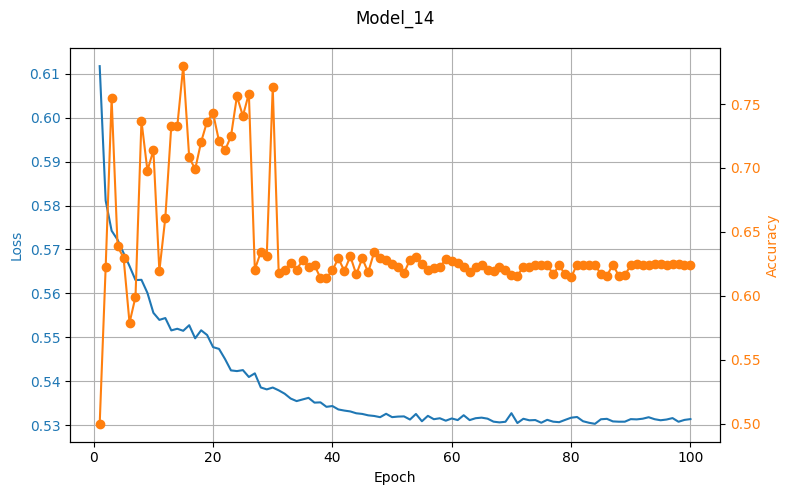

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Model to test: Model_21
feature_dim: 4096
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7ff27a492260>


Epoch 13/100 loss=0.5606 val_acc=0.6508 best=0.7407:  13%|▏| 13/100 [23:17<2:34:

Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/100 loss=0.5482 val_acc=0.6025 best=0.7407:  19%|▏| 19/100 [34:04<2:25:

Epoch 00019: reducing learning rate of group 0 to 2.5000e-04.


Epoch 46/100 loss=0.5347 val_acc=0.7522 best=0.7785:  46%|▍| 46/100 [1:21:51<1:3

Epoch 00046: reducing learning rate of group 0 to 1.2500e-04.


Epoch 52/100 loss=0.5296 val_acc=0.7643 best=0.7785:  52%|▌| 52/100 [1:32:34<1:2

Epoch 00052: reducing learning rate of group 0 to 6.2500e-05.


Epoch 58/100 loss=0.5257 val_acc=0.7604 best=0.7785:  58%|▌| 58/100 [1:43:11<1:1

Epoch 00058: reducing learning rate of group 0 to 3.1250e-05.


Epoch 64/100 loss=0.5256 val_acc=0.7686 best=0.7785:  64%|▋| 64/100 [1:53:56<1:0

Epoch 00064: reducing learning rate of group 0 to 1.5625e-05.


Epoch 70/100 loss=0.5246 val_acc=0.7714 best=0.7785:  70%|▋| 70/100 [2:04:40<53:

Epoch 00070: reducing learning rate of group 0 to 7.8125e-06.


Epoch 76/100 loss=0.5237 val_acc=0.7681 best=0.7785:  76%|▊| 76/100 [2:15:25<43:

Epoch 00076: reducing learning rate of group 0 to 3.9063e-06.


Epoch 82/100 loss=0.5223 val_acc=0.7714 best=0.7785:  82%|▊| 82/100 [2:26:05<31:

Epoch 00082: reducing learning rate of group 0 to 1.9531e-06.


Epoch 88/100 loss=0.5226 val_acc=0.7708 best=0.7785:  88%|▉| 88/100 [2:36:43<21:

Epoch 00088: reducing learning rate of group 0 to 9.7656e-07.


Epoch 94/100 loss=0.5231 val_acc=0.7719 best=0.7785:  94%|▉| 94/100 [2:47:29<10:

Epoch 00094: reducing learning rate of group 0 to 4.8828e-07.


Epoch 100/100 loss=0.5223 val_acc=0.7736 best=0.7785: 100%|█| 100/100 [2:58:17<0

Epoch 00100: reducing learning rate of group 0 to 2.4414e-07.
Best val accuracy: 0.7785087719298246


Final TEST accuracy: 0.7854785478547854


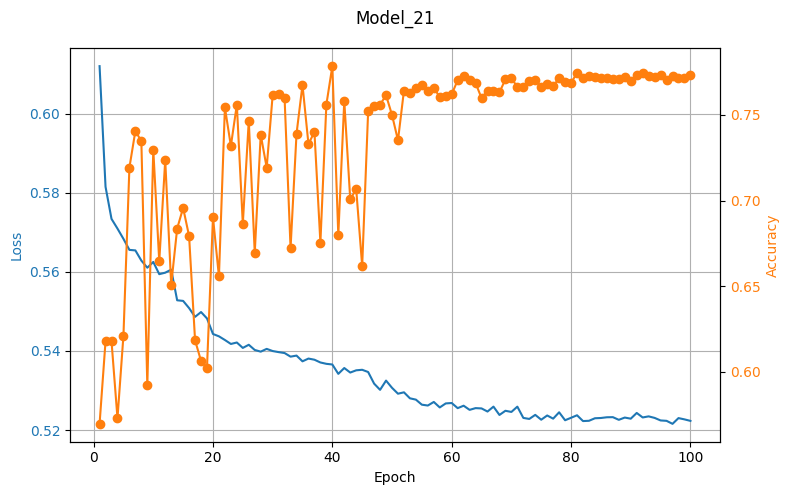

Model to test: Model_20
feature_dim: 2048
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7ff27a4f3310>


Epoch 20/100 loss=0.5561 val_acc=0.7270 best=0.7511:  20%|▏| 20/100 [1:35:19<6:4

Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.


Epoch 26/100 loss=0.5434 val_acc=0.6639 best=0.7511:  26%|▎| 26/100 [2:05:22<6:1

Epoch 00026: reducing learning rate of group 0 to 2.5000e-04.


Epoch 32/100 loss=0.5384 val_acc=0.7336 best=0.7511:  32%|▎| 32/100 [2:35:37<5:4

Epoch 00032: reducing learning rate of group 0 to 1.2500e-04.


Epoch 39/100 loss=0.5341 val_acc=0.7467 best=0.7610:  39%|▍| 39/100 [3:10:57<5:0

Epoch 00039: reducing learning rate of group 0 to 6.2500e-05.


Epoch 46/100 loss=0.5312 val_acc=0.7242 best=0.7643:  46%|▍| 46/100 [3:46:14<4:3

Epoch 00046: reducing learning rate of group 0 to 3.1250e-05.


Epoch 52/100 loss=0.5296 val_acc=0.7039 best=0.7643:  52%|▌| 52/100 [4:16:32<4:0

Epoch 00052: reducing learning rate of group 0 to 1.5625e-05.


Epoch 58/100 loss=0.5286 val_acc=0.7204 best=0.7643:  58%|▌| 58/100 [4:47:07<3:3

Epoch 00058: reducing learning rate of group 0 to 7.8125e-06.


Epoch 64/100 loss=0.5290 val_acc=0.7050 best=0.7643:  64%|▋| 64/100 [5:17:36<3:0

Epoch 00064: reducing learning rate of group 0 to 3.9063e-06.


Epoch 70/100 loss=0.5299 val_acc=0.7155 best=0.7643:  70%|▋| 70/100 [5:47:57<2:3

Epoch 00070: reducing learning rate of group 0 to 1.9531e-06.


Epoch 76/100 loss=0.5287 val_acc=0.7083 best=0.7643:  76%|▊| 76/100 [6:17:09<1:5

Epoch 00076: reducing learning rate of group 0 to 9.7656e-07.


Epoch 82/100 loss=0.5294 val_acc=0.7111 best=0.7643:  82%|▊| 82/100 [6:47:14<1:2

Epoch 00082: reducing learning rate of group 0 to 4.8828e-07.


Epoch 88/100 loss=0.5290 val_acc=0.7182 best=0.7643:  88%|▉| 88/100 [7:18:53<1:0

Epoch 00088: reducing learning rate of group 0 to 2.4414e-07.


Epoch 94/100 loss=0.5283 val_acc=0.7122 best=0.7643:  94%|▉| 94/100 [7:48:53<30:

Epoch 00094: reducing learning rate of group 0 to 1.2207e-07.


Epoch 100/100 loss=0.5291 val_acc=0.7127 best=0.7643: 100%|█| 100/100 [8:19:17<0

Epoch 00100: reducing learning rate of group 0 to 6.1035e-08.
Best val accuracy: 0.7642543859649122


Final TEST accuracy: 0.757975797579758


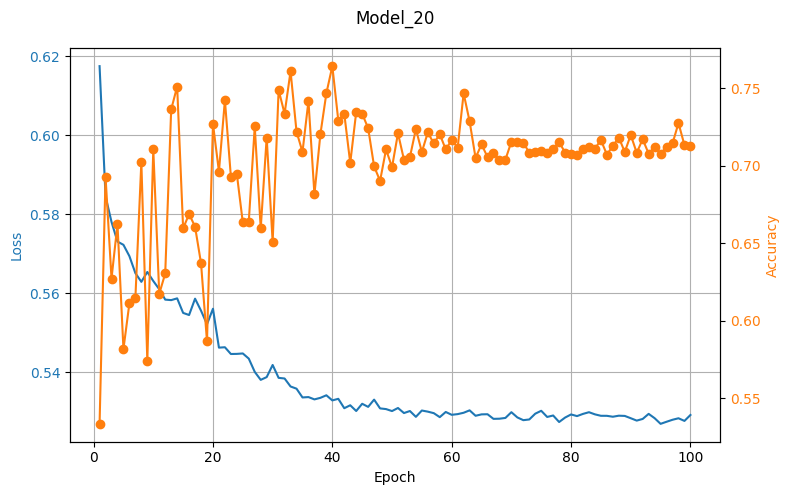

Model to test: Model_13
feature_dim: 16384
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7ff27a5688b0>


Epoch 13/100 loss=0.5458 val_acc=0.7599 best=0.7637:  13%|▏| 13/100 [27:15<3:00:

Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.


Epoch 24/100 loss=0.5258 val_acc=0.7615 best=0.8010:  24%|▏| 24/100 [50:00<2:38:

Epoch 00024: reducing learning rate of group 0 to 2.5000e-04.


Epoch 37/100 loss=0.5141 val_acc=0.8087 best=0.8174:  37%|▎| 37/100 [1:16:53<2:1

Epoch 00037: reducing learning rate of group 0 to 1.2500e-04.


Epoch 43/100 loss=0.5049 val_acc=0.7856 best=0.8174:  43%|▍| 43/100 [1:29:13<1:5

Epoch 00043: reducing learning rate of group 0 to 6.2500e-05.


Epoch 49/100 loss=0.5026 val_acc=0.7867 best=0.8174:  49%|▍| 49/100 [1:41:36<1:4

Epoch 00049: reducing learning rate of group 0 to 3.1250e-05.


Epoch 55/100 loss=0.5008 val_acc=0.7922 best=0.8174:  55%|▌| 55/100 [1:54:04<1:3

Epoch 00055: reducing learning rate of group 0 to 1.5625e-05.


Epoch 61/100 loss=0.4981 val_acc=0.7867 best=0.8174:  61%|▌| 61/100 [2:06:23<1:1

Epoch 00061: reducing learning rate of group 0 to 7.8125e-06.


Epoch 67/100 loss=0.4971 val_acc=0.7829 best=0.8174:  67%|▋| 67/100 [2:18:48<1:0

Epoch 00067: reducing learning rate of group 0 to 3.9063e-06.


Epoch 73/100 loss=0.4962 val_acc=0.7774 best=0.8174:  73%|▋| 73/100 [2:31:09<55:

Epoch 00073: reducing learning rate of group 0 to 1.9531e-06.


Epoch 79/100 loss=0.4953 val_acc=0.7763 best=0.8174:  79%|▊| 79/100 [2:43:43<43:

Epoch 00079: reducing learning rate of group 0 to 9.7656e-07.


Epoch 85/100 loss=0.4979 val_acc=0.7747 best=0.8174:  85%|▊| 85/100 [2:56:05<31:

Epoch 00085: reducing learning rate of group 0 to 4.8828e-07.


Epoch 91/100 loss=0.4973 val_acc=0.7774 best=0.8174:  91%|▉| 91/100 [3:08:37<18:

Epoch 00091: reducing learning rate of group 0 to 2.4414e-07.


Epoch 97/100 loss=0.4970 val_acc=0.7834 best=0.8174:  97%|▉| 97/100 [3:21:17<06:

Epoch 00097: reducing learning rate of group 0 to 1.2207e-07.


Epoch 100/100 loss=0.4974 val_acc=0.7769 best=0.8174: 100%|█| 100/100 [3:27:41<0

Best val accuracy: 0.8174342105263158


Final TEST accuracy: 0.8250825082508251


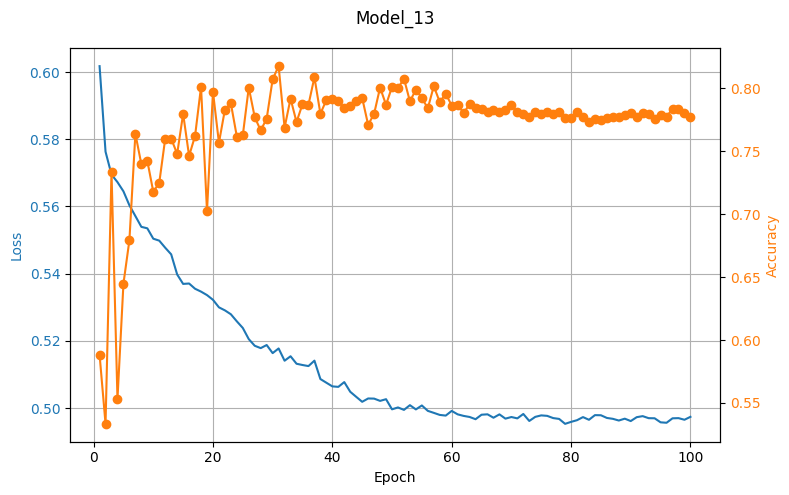

Model to test: Model_16
feature_dim: 3072
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7ff27a470040>


Epoch 13/100 loss=0.5533 val_acc=0.7418 best=0.7637:  13%|▏| 13/100 [30:06<3:19:

Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/100 loss=0.5447 val_acc=0.6963 best=0.7637:  19%|▏| 19/100 [43:55<3:05:

Epoch 00019: reducing learning rate of group 0 to 2.5000e-04.


Epoch 31/100 loss=0.5365 val_acc=0.7522 best=0.7791:  31%|▎| 31/100 [1:11:38<2:3

Epoch 00031: reducing learning rate of group 0 to 1.2500e-04.


Epoch 37/100 loss=0.5334 val_acc=0.7067 best=0.7791:  37%|▎| 37/100 [1:25:35<2:2

Epoch 00037: reducing learning rate of group 0 to 6.2500e-05.


Epoch 43/100 loss=0.5336 val_acc=0.7336 best=0.7791:  43%|▍| 43/100 [1:39:23<2:1

Epoch 00043: reducing learning rate of group 0 to 3.1250e-05.


Epoch 49/100 loss=0.5308 val_acc=0.7379 best=0.7791:  49%|▍| 49/100 [1:53:11<1:5

Epoch 00049: reducing learning rate of group 0 to 1.5625e-05.


Epoch 55/100 loss=0.5292 val_acc=0.7160 best=0.7791:  55%|▌| 55/100 [2:07:07<1:4

Epoch 00055: reducing learning rate of group 0 to 7.8125e-06.


Epoch 61/100 loss=0.5303 val_acc=0.6453 best=0.7791:  61%|▌| 61/100 [2:20:58<1:2

Epoch 00061: reducing learning rate of group 0 to 3.9063e-06.


Epoch 67/100 loss=0.5296 val_acc=0.7390 best=0.7791:  67%|▋| 67/100 [2:34:58<1:1

Epoch 00067: reducing learning rate of group 0 to 1.9531e-06.


Epoch 73/100 loss=0.5291 val_acc=0.6913 best=0.7791:  73%|▋| 73/100 [2:48:59<1:0

Epoch 00073: reducing learning rate of group 0 to 9.7656e-07.


Epoch 79/100 loss=0.5278 val_acc=0.6168 best=0.7791:  79%|▊| 79/100 [3:02:47<48:

Epoch 00079: reducing learning rate of group 0 to 4.8828e-07.


Epoch 85/100 loss=0.5284 val_acc=0.7215 best=0.7791:  85%|▊| 85/100 [3:16:39<34:

Epoch 00085: reducing learning rate of group 0 to 2.4414e-07.


Epoch 91/100 loss=0.5294 val_acc=0.7144 best=0.7791:  91%|▉| 91/100 [3:30:33<20:

Epoch 00091: reducing learning rate of group 0 to 1.2207e-07.


Epoch 97/100 loss=0.5292 val_acc=0.7133 best=0.7791:  97%|▉| 97/100 [3:44:23<06:

Epoch 00097: reducing learning rate of group 0 to 6.1035e-08.


Epoch 100/100 loss=0.5299 val_acc=0.7401 best=0.7791: 100%|█| 100/100 [3:51:24<0

Best val accuracy: 0.7790570175438597


Final TEST accuracy: 0.7744774477447744


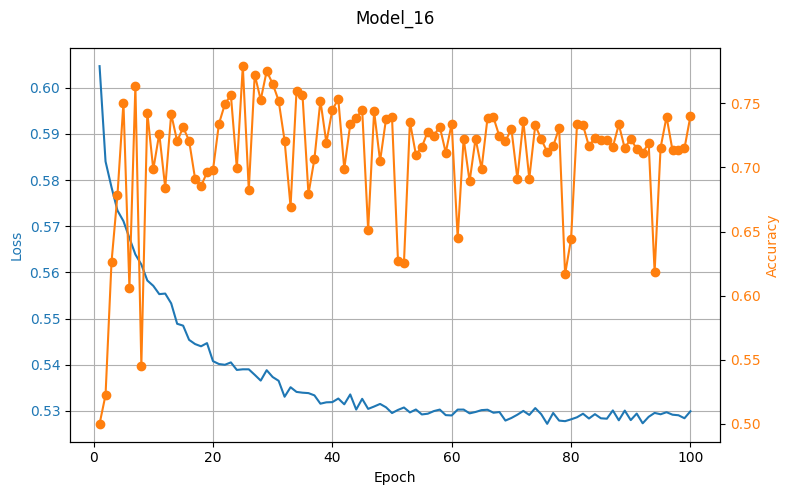

Model to test: Model_17
feature_dim: 4096
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7ff27a4f3730>


Epoch 7/100 loss=0.5676 val_acc=0.6047 best=0.6902:   7%| | 7/100 [13:47<3:00:33

Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/100 loss=0.5551 val_acc=0.6360 best=0.7829:  15%|▏| 15/100 [29:19<2:44:

Epoch 00015: reducing learning rate of group 0 to 2.5000e-04.


Epoch 21/100 loss=0.5485 val_acc=0.7346 best=0.7829:  21%|▏| 21/100 [40:52<2:31:

Epoch 00021: reducing learning rate of group 0 to 1.2500e-04.


Epoch 27/100 loss=0.5444 val_acc=0.6820 best=0.7829:  27%|▎| 27/100 [50:41<2:05:

Epoch 00027: reducing learning rate of group 0 to 6.2500e-05.


Epoch 33/100 loss=0.5410 val_acc=0.6535 best=0.7829:  33%|▎| 33/100 [1:00:27<1:5

Epoch 00033: reducing learning rate of group 0 to 3.1250e-05.


Epoch 39/100 loss=0.5393 val_acc=0.6732 best=0.7829:  39%|▍| 39/100 [1:10:58<1:4

Epoch 00039: reducing learning rate of group 0 to 1.5625e-05.


Epoch 45/100 loss=0.5387 val_acc=0.7204 best=0.7829:  45%|▍| 45/100 [1:21:27<1:3

Epoch 00045: reducing learning rate of group 0 to 7.8125e-06.


Epoch 51/100 loss=0.5376 val_acc=0.7166 best=0.7829:  51%|▌| 51/100 [1:31:28<1:2

Epoch 00051: reducing learning rate of group 0 to 3.9063e-06.


Epoch 57/100 loss=0.5394 val_acc=0.7100 best=0.7829:  57%|▌| 57/100 [1:41:14<1:1

Epoch 00057: reducing learning rate of group 0 to 1.9531e-06.


Epoch 63/100 loss=0.5377 val_acc=0.6661 best=0.7829:  63%|▋| 63/100 [1:51:46<1:0

Epoch 00063: reducing learning rate of group 0 to 9.7656e-07.


Epoch 69/100 loss=0.5388 val_acc=0.7127 best=0.7829:  69%|▋| 69/100 [2:02:20<54:

Epoch 00069: reducing learning rate of group 0 to 4.8828e-07.


Epoch 75/100 loss=0.5390 val_acc=0.6656 best=0.7829:  75%|▊| 75/100 [2:12:46<43:

Epoch 00075: reducing learning rate of group 0 to 2.4414e-07.


Epoch 81/100 loss=0.5376 val_acc=0.7116 best=0.7829:  81%|▊| 81/100 [2:23:12<33:

Epoch 00081: reducing learning rate of group 0 to 1.2207e-07.


Epoch 87/100 loss=0.5383 val_acc=0.7116 best=0.7829:  87%|▊| 87/100 [2:33:36<22:

Epoch 00087: reducing learning rate of group 0 to 6.1035e-08.


Epoch 93/100 loss=0.5380 val_acc=0.6820 best=0.7829:  93%|▉| 93/100 [2:44:01<12:

Epoch 00093: reducing learning rate of group 0 to 3.0518e-08.


Epoch 99/100 loss=0.5382 val_acc=0.7105 best=0.7829:  99%|▉| 99/100 [2:54:19<01:

Epoch 00099: reducing learning rate of group 0 to 1.5259e-08.


Epoch 100/100 loss=0.5376 val_acc=0.7105 best=0.7829: 100%|█| 100/100 [2:56:03<0

Best val accuracy: 0.7828947368421053


Final TEST accuracy: 0.7920792079207921


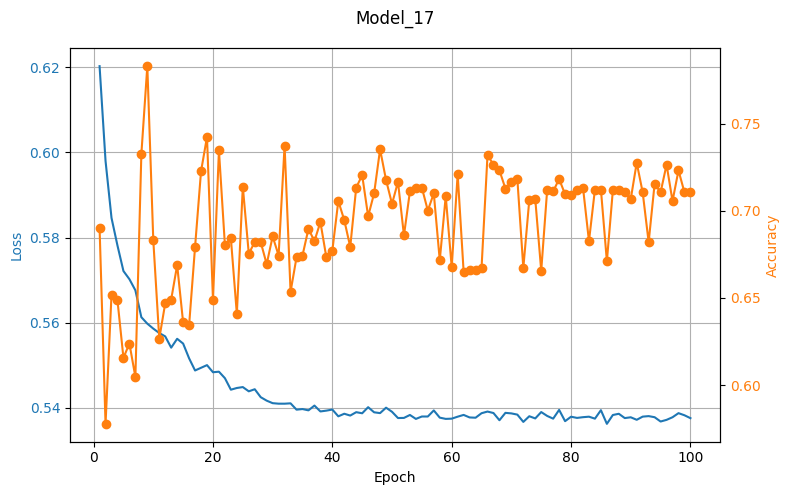

Model to test: Model_18
feature_dim: 2048
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7ff27a471ae0>


Epoch 24/100 loss=0.5447 val_acc=0.5932 best=0.7566:  24%|▏| 24/100 [38:50<2:02:

Epoch 00024: reducing learning rate of group 0 to 5.0000e-04.


Epoch 30/100 loss=0.5384 val_acc=0.6069 best=0.7566:  30%|▎| 30/100 [48:39<1:54:

Epoch 00030: reducing learning rate of group 0 to 2.5000e-04.


Epoch 36/100 loss=0.5338 val_acc=0.6250 best=0.7566:  36%|▎| 36/100 [58:21<1:43:

Epoch 00036: reducing learning rate of group 0 to 1.2500e-04.


Epoch 42/100 loss=0.5312 val_acc=0.6255 best=0.7566:  42%|▍| 42/100 [1:08:03<1:3

Epoch 00042: reducing learning rate of group 0 to 6.2500e-05.


Epoch 48/100 loss=0.5288 val_acc=0.6245 best=0.7566:  48%|▍| 48/100 [1:17:43<1:2

Epoch 00048: reducing learning rate of group 0 to 3.1250e-05.


Epoch 54/100 loss=0.5283 val_acc=0.6294 best=0.7566:  54%|▌| 54/100 [1:27:23<1:1

Epoch 00054: reducing learning rate of group 0 to 1.5625e-05.


Epoch 60/100 loss=0.5281 val_acc=0.6294 best=0.7566:  60%|▌| 60/100 [1:37:12<1:0

Epoch 00060: reducing learning rate of group 0 to 7.8125e-06.


Epoch 66/100 loss=0.5270 val_acc=0.6255 best=0.7566:  66%|▋| 66/100 [1:46:53<54:

Epoch 00066: reducing learning rate of group 0 to 3.9063e-06.


Epoch 72/100 loss=0.5270 val_acc=0.6245 best=0.7566:  72%|▋| 72/100 [1:56:43<45:

Epoch 00072: reducing learning rate of group 0 to 1.9531e-06.


Epoch 78/100 loss=0.5258 val_acc=0.6277 best=0.7566:  78%|▊| 78/100 [2:06:27<35:

Epoch 00078: reducing learning rate of group 0 to 9.7656e-07.


Epoch 84/100 loss=0.5268 val_acc=0.6288 best=0.7566:  84%|▊| 84/100 [2:16:10<25:

Epoch 00084: reducing learning rate of group 0 to 4.8828e-07.


Epoch 90/100 loss=0.5279 val_acc=0.6299 best=0.7566:  90%|▉| 90/100 [2:25:52<16:

Epoch 00090: reducing learning rate of group 0 to 2.4414e-07.


Epoch 96/100 loss=0.5262 val_acc=0.6288 best=0.7566:  96%|▉| 96/100 [2:35:31<06:

Epoch 00096: reducing learning rate of group 0 to 1.2207e-07.


Epoch 100/100 loss=0.5267 val_acc=0.6305 best=0.7566: 100%|█| 100/100 [2:42:00<0

Best val accuracy: 0.756578947368421


Final TEST accuracy: 0.7546754675467546


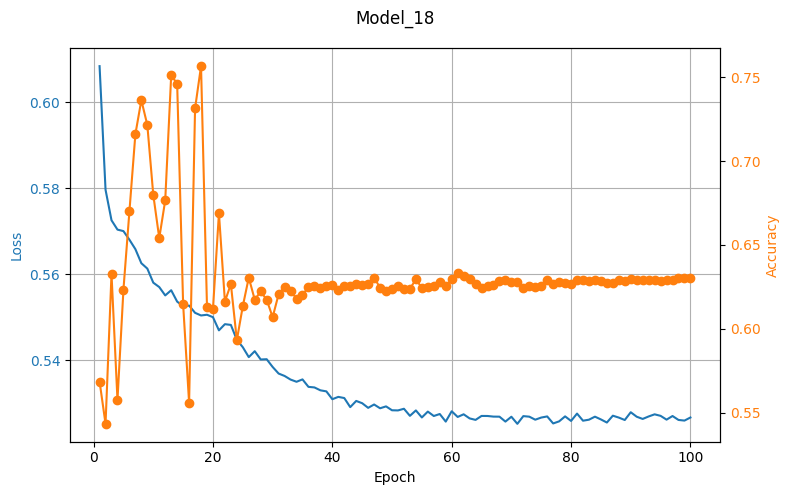

Model to test: Model_19
feature_dim: 1536
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7ff2791509d0>


Epoch 21/100 loss=0.5481 val_acc=0.6968 best=0.7478:  21%|▏| 21/100 [25:29<1:34:

Epoch 00021: reducing learning rate of group 0 to 5.0000e-04.


Epoch 50/100 loss=0.5257 val_acc=0.7999 best=0.8427:  50%|▌| 50/100 [1:00:37<1:0

Epoch 00050: reducing learning rate of group 0 to 2.5000e-04.


Epoch 56/100 loss=0.5184 val_acc=0.7884 best=0.8427:  56%|▌| 56/100 [1:07:54<52:

Epoch 00056: reducing learning rate of group 0 to 1.2500e-04.


Epoch 62/100 loss=0.5121 val_acc=0.7823 best=0.8427:  62%|▌| 62/100 [1:15:16<46:

Epoch 00062: reducing learning rate of group 0 to 6.2500e-05.


Epoch 68/100 loss=0.5084 val_acc=0.7862 best=0.8427:  68%|▋| 68/100 [1:22:27<38:

Epoch 00068: reducing learning rate of group 0 to 3.1250e-05.


Epoch 74/100 loss=0.5033 val_acc=0.7977 best=0.8427:  74%|▋| 74/100 [1:29:49<31:

Epoch 00074: reducing learning rate of group 0 to 1.5625e-05.


Epoch 80/100 loss=0.5046 val_acc=0.7961 best=0.8427:  80%|▊| 80/100 [1:37:06<24:

Epoch 00080: reducing learning rate of group 0 to 7.8125e-06.


Epoch 86/100 loss=0.5030 val_acc=0.7928 best=0.8427:  86%|▊| 86/100 [1:44:22<16:

Epoch 00086: reducing learning rate of group 0 to 3.9063e-06.


Epoch 92/100 loss=0.5021 val_acc=0.7928 best=0.8427:  92%|▉| 92/100 [1:51:32<09:

Epoch 00092: reducing learning rate of group 0 to 1.9531e-06.


Epoch 98/100 loss=0.5009 val_acc=0.7933 best=0.8427:  98%|▉| 98/100 [1:58:50<02:

Epoch 00098: reducing learning rate of group 0 to 9.7656e-07.


Epoch 100/100 loss=0.5012 val_acc=0.7906 best=0.8427: 100%|█| 100/100 [2:01:14<0

Best val accuracy: 0.8426535087719298


Final TEST accuracy: 0.8305830583058306


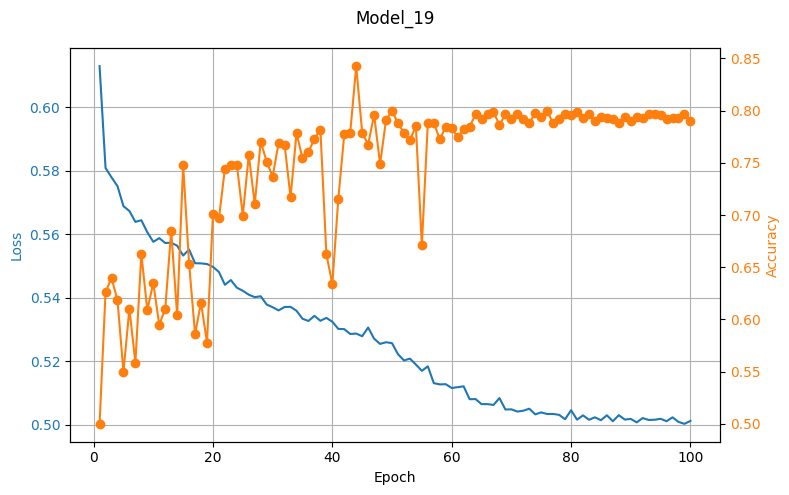

In [35]:
# run_experiment(Model8_Bottleneck1x1, "Model_8", 100)
# run_experiment(Model9_VGGLite, "Model_9", 100)
# run_experiment(Model10_MorePooling, "Model_10", 100)
# run_experiment(Model11_CappedChannels, "Model_11", 100)
# run_experiment(Model12_ShrinkBeforeFC, "Model_12", 100)
# run_experiment(Model15_2conv_stages, "Model_15", 100)
run_experiment(Model22_extra_conv_mid, "Model_22", 100)
run_experiment(Model14_VGGmini_morepool, "Model_14", 100)
run_experiment(Model21_late64, "Model_21", 100)
run_experiment(Model20_all32, "Model_20", 100)
run_experiment(Model13_VGGmini, "Model_13", 100)
run_experiment(Model16_wide_early, "Model_16", 100)
run_experiment(Model17_deeper_4blocks, "Model_17", 100)
run_experiment(Model18_bigger_head, "Model_18", 100)
run_experiment(Model19_lowchan_deeper, "Model_19", 100)